# Machine Learning Nanodegree Capstone

## Supervised regression of LC loan data

As my metric (buy rate) is a continuous function, I have turned a simple classification (good vs bad loans) into a regression of return. I find that this would be a better tool for picking loans to invest in, as it forecasts a predicted return, not just if the loan will be paid as agreed. My metric intereacts with the loan interest, prefering higher interest loans that are paid as agreed over lower interest loans, this is not done by simple classification. Successful forecasting of my metric can be the difference between having no defaulting loans, but a 4% return per year (low interest, safe loans) vs having no or few defaulting loans, and 10-15% return per year.


### Getting started

Data exploration and cleaning has been performed using the previous jupyter notebook named "Data Cleaning.ipynb". I exported a clean features and labels pickle using joblib in that notebook. I will import them and graph some preliminary things to start!

In [1]:
import joblib
features=joblib.load('clean_LCfeatures.p')
labels=joblib.load('clean_LClabels.p')

In [2]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


In [3]:
features.head(n=10)

,emp_title,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med
0,None,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,0.0
1,None,10.0,RENT,12252.0,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,0.0
2,AIR RESOURCES BOARD,10.0,RENT,49200.0,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,0.0
3,Veolia Transportaton,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963.0,28.3,12.0,0.0
4,MKC Accounting,9.0,RENT,48000.0,car,CA,5.35,0.0,2007-01-01,2.0,4.0,0.0,8221.0,87.5,4.0,0.0
5,UCLA,10.0,OWN,75000.0,debt_consolidation,CA,10.78,0.0,1989-10-01,0.0,12.0,0.0,23336.0,67.1,34.0,0.0
6,Va. Dept of Conservation/Recreation,0.5,RENT,30000.0,debt_consolidation,VA,10.08,0.0,2004-04-01,1.0,4.0,0.0,10452.0,91.7,9.0,0.0
7,Target,3.0,RENT,15000.0,credit_card,IL,12.56,0.0,2003-07-01,2.0,11.0,0.0,7323.0,43.1,11.0,0.0
8,SFMTA,3.0,RENT,100000.0,other,CA,7.06,0.0,1991-05-01,2.0,14.0,0.0,11997.0,55.5,29.0,0.0
9,Internal revenue Service,0.5,RENT,28000.0,debt_consolidation,MO,20.31,0.0,2007-09-01,1.0,11.0,0.0,6524.0,81.5,23.0,0.0


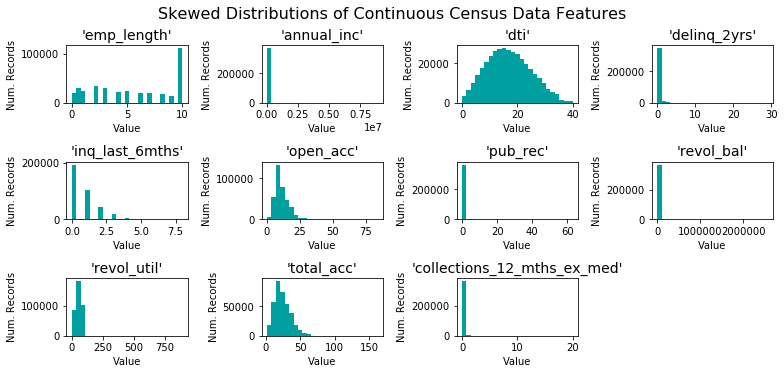

In [5]:
import imp
imp.reload(vs)
vs.distribution(features)